# Классификация видеороликов на YouTube

**Заказчик**  
Компания "Союзмультфильм". Основной вид деятельности Студии "Союзмультфильм" - производство контента, анимационных фильмов.  

**Описание проекта**  
Студия для оценки популярности проектов мониторит рынок и собирает статистику. И очень важно агрегировать статистику именно по проектам, а не отдельным роликам. Поэтому ролики классифицируются по принадлежности к проектам. Необходимо создать автоматизированное решение по определению принадлежности ролика к тому или иному проекту на основе анализа текстового описания видеороликов и другой доступной информации. 

**Цель**  
Предложить решение для классификации роликов по проектам.
1. Максимизировать метрику f1
2. Создать модуль (класс, функцию) для определения проекта: 
    * на вход подается список уникальных идентификаторов yt_reel_id
    * на выходе словарь {‘yt_reel_id’: идентификатор, ‘cartoon’: название_проекта_или_none}
    * для роликов, которые не входят ни в один проект, в поле cartoon должна возвращаться строка ‘none’

**Описание данных**
|Параметр|Описание|
|---|---|
|date|дата, когда ролик появился на ютубе  |
|reel_name|название ролика  |
|yt_reel_id  |уникальный идентификатор ролика на ютубе  |
|cartoon |название проекта, целевая переменная  |
|url |ссылка на ролик (включает идентификатор)  |
|text |текст сниппета, включает название ролика и описание  |
|seconds | длительность|
|is_shorts | вертикальные видеоролики продолжительностью <60сек  |
|broadcast | лайвы, прямые эфиры|
|yt_channel_id |идентификатор ютуб канала  |
|yt_channel_name |название ютуб канала  |
|yt_ch_url |ссылка на ютуб канал  |
|yt_channel_type |тип канала (Мультфильмы, Детские, Блогеры, Shorts…)  |
|flag_closed |ютуб канал закрыт, если 1  |
|international |метка международных каналов, каналов на иностранном языке (переведенный контент)  |
|language| язык|

**План работы**
1. Исследовательский анализ данных. 
2. Создание базового решения. 
3. Эксперименты, максимизация метрики качества модели.
4. Оформление итогового решения в виде модуля, оформление документации и отчета.

## Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV

from pymystem3 import Mystem
import joblib

from own_functions import data_review, describe_col_plot, text_lemmatizer, text_cleaning,  \
                            data_enrichment, target_correction, matrix_preparation

## Исследовательский анализ данных

In [2]:
# Загрузка тренировочного сета
df_train = pd.read_csv('../data/train.csv', lineterminator='\n', parse_dates=True)
df_train.head(3)

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN


In [3]:
# Обзорная информация о датасете
data_review(df_train)

Количество строк: 83411 
Количество столбцов: 16 
Явных дубликатов: 0


,Имя столбца,Тип данных,Уникальных значений,"Доля уник.знач., %",Число пропусков,"Доля пропусков, %"
0,date,object,4634,5.6,0,0.00
1,reel_name,object,77223,92.6,3,0.00
2,yt_reel_id,object,83411,100.0,0,0.00
3,cartoon,object,45,0.1,0,0.00
4,url,object,83411,100.0,0,0.00
5,text,object,78857,94.5,0,0.00
6,seconds,float64,6688,8.0,8758,10.50
7,is_shorts,float64,3,0.0,8758,10.50
8,broadcast,object,4,0.0,8758,10.50
9,yt_channel_id,object,206,0.2,45,0.05


### cartoon (таргет)

In [4]:
# Оценим количество роликов для каждого класса таргета
df_train.cartoon.value_counts().apply([lambda x: x, lambda x: str(round(x / len(df_train) * 100, 2))+'%'])

,<lambda>,<lambda>
cartoon,,
none,78231,93.79%
Маша и медведь,853,1.02%
Говорящий Том,589,0.71%
Буба,529,0.63%
Кошечки собачки,437,0.52%
Енотки,379,0.45%
Бэтмен,353,0.42%
ЖилаБыла Царевна,229,0.27%
Оранжевая корова,227,0.27%


### date

In [5]:
# Преобразуем тип данных в datetime64
df_train.date = pd.to_datetime(df_train.date)
print(df_train.dtypes['date'])

datetime64[ns]


In [6]:
# Оценим диапазон дат
print(f'Диапазон дат публикации роликов: от {df_train.date.min()} до {df_train.date.max()}')

Диапазон дат публикации роликов: от 2008-10-08 00:00:00 до 2024-09-15 00:00:00


In [7]:
# Выделим год публикации в отдельную фичу
df_train['publication_year'] = df_train.date.dt.year
df_train.head(3)

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,publication_year
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN,2023
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN,2018
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN,2023


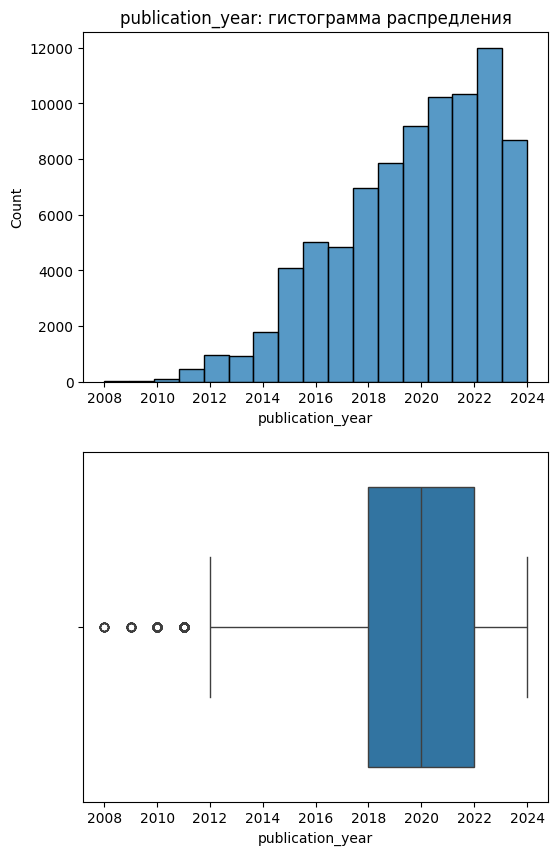

In [8]:
describe_col_plot(df_train, 'publication_year', bins=17)

### reel_name

In [9]:
# Посмотрим на пропущенные значения
df_train[df_train.reel_name.isna()]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,publication_year
15331,2024-09-07,NaN,_S1ro6h6Ils,none,https://www.youtube.com/watch?v=_S1ro6h6Ils,[],19.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN,2024
17756,2023-01-09,NaN,daJ0drzcYz4,none,https://www.youtube.com/watch?v=daJ0drzcYz4,[] shorts shortsviral babyalive deixaolike],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,2023
66766,2022-11-08,NaN,Zu_vwE48tqI,none,https://www.youtube.com/watch?v=Zu_vwE48tqI,[] shortsviral babyalive babyalive brincadeira],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,2022


In [10]:
# Удалим три строки с пропусками
df_train.drop(index=df_train[df_train.reel_name.isna()].index, inplace=True)
df_train.reel_name.isna().sum()

np.int64(0)

In [11]:
# Оценим максимальную и минимальную длину строки reel_name
print(f'Максимальная длина строки: {df_train.reel_name.str.len().max()} \nМинимальная длина строки {df_train.reel_name.str.len().min()}')

Максимальная длина строки: 177 
Минимальная длина строки 1


In [12]:
# Посмотрим на примеры записей с длиной reel_name 3 и менее
df_train[df_train.reel_name.str.len() <= 3].sample(7)

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,publication_year
21038,2017-04-06,[EN,4ALzZeFaNhE,none,https://www.youtube.com/watch?v=4ALzZeFaNhE,[[EN] Изучение английского языка с пороро Дин...,1819.0,0.0,none,UCqBK7lTX1Msb-BqyLLgBhAg,Пороро,https://youtube.com/channel/UCqBK7lTX1Msb-BqyL...,Мультфильмы,0.0,0.0,NaN,2017
25884,2017-09-25,[EN,I1Np1Fh1P7I,none,https://www.youtube.com/watch?v=I1Np1Fh1P7I,[[EN] 11Серия Вы умеете плавать Can you swim ...,2884.0,0.0,none,UCqBK7lTX1Msb-BqyLLgBhAg,Пороро,https://youtube.com/channel/UCqBK7lTX1Msb-BqyL...,Мультфильмы,0.0,0.0,NaN,2017
70287,2021-08-17,kkk,i1GnWBKlZUc,none,https://www.youtube.com/watch?v=i1GnWBKlZUc,[kkk],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,2021
70319,2017-05-04,[EN,ScC_vx4EhsE,none,https://www.youtube.com/watch?v=ScC_vx4EhsE,[[EN] Изучение английского языка с пороро Все...,1818.0,0.0,none,UCqBK7lTX1Msb-BqyLLgBhAg,Пороро,https://youtube.com/channel/UCqBK7lTX1Msb-BqyL...,Мультфильмы,0.0,0.0,NaN,2017
49169,2021-09-17,3,NhZmjMa3E2s,none,https://www.youtube.com/watch?v=NhZmjMa3E2s,[3],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN,2021
29154,2017-05-18,[EN,sXzHkyogf5Q,none,https://www.youtube.com/watch?v=sXzHkyogf5Q,[[EN] Изучение английского языка с пороро Мам...,1818.0,0.0,none,UCqBK7lTX1Msb-BqyLLgBhAg,Пороро,https://youtube.com/channel/UCqBK7lTX1Msb-BqyL...,Мультфильмы,0.0,0.0,NaN,2017
38966,2017-06-28,[EN,Mshv6GC7jWU,none,https://www.youtube.com/watch?v=Mshv6GC7jWU,[[EN] Изучение английского языка с пороро 1Се...,2359.0,0.0,none,UCqBK7lTX1Msb-BqyLLgBhAg,Пороро,https://youtube.com/channel/UCqBK7lTX1Msb-BqyL...,Мультфильмы,0.0,0.0,NaN,2017


In [13]:
# Оценим среднюю длину строки reel_name
df_train['reel_name_len'] = df_train.reel_name.str.len()
print(f'Средняя длина строки reel_name: {df_train.reel_name_len.mean():.2f} \nСт.отклонение {df_train.reel_name_len.std():.2f}')
df_train.drop(columns='reel_name_len', inplace=True)

Средняя длина строки reel_name: 59.44 
Ст.отклонение 20.12


### text

count    83408.000000
mean       941.679383
std        809.679315
min          4.000000
25%        392.000000
50%        756.000000
75%       1223.000000
max      10050.000000
Name: text_len, dtype: float64

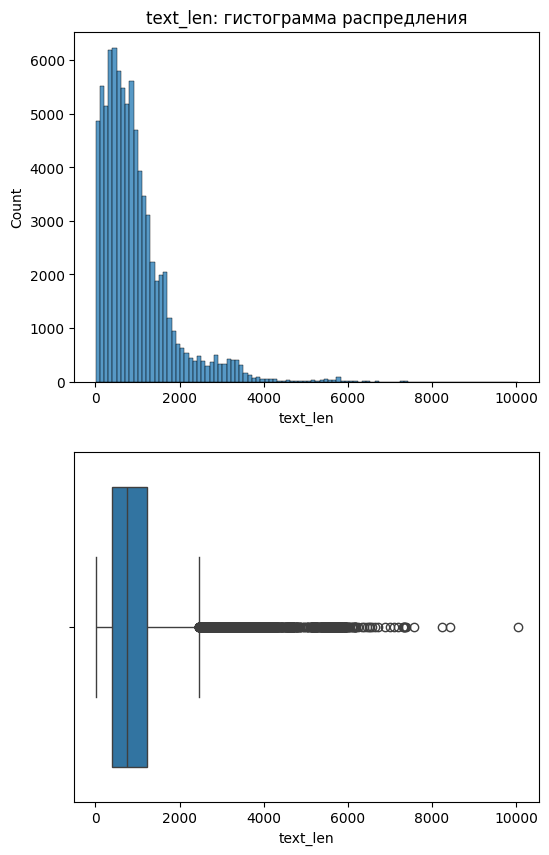

In [14]:
# Оценим среднюю длину строки сниппета (text)
df_train['text_len'] = df_train.text.str.len()
describe_col_plot(df_train, 'text_len', bins=100)
df_train.text_len.describe()

### seconds

count     74652.000000
mean       1921.314566
std        7097.940373
min           0.000000
25%         200.000000
50%         602.000000
75%        1316.000000
max      504055.000000
Name: seconds, dtype: float64

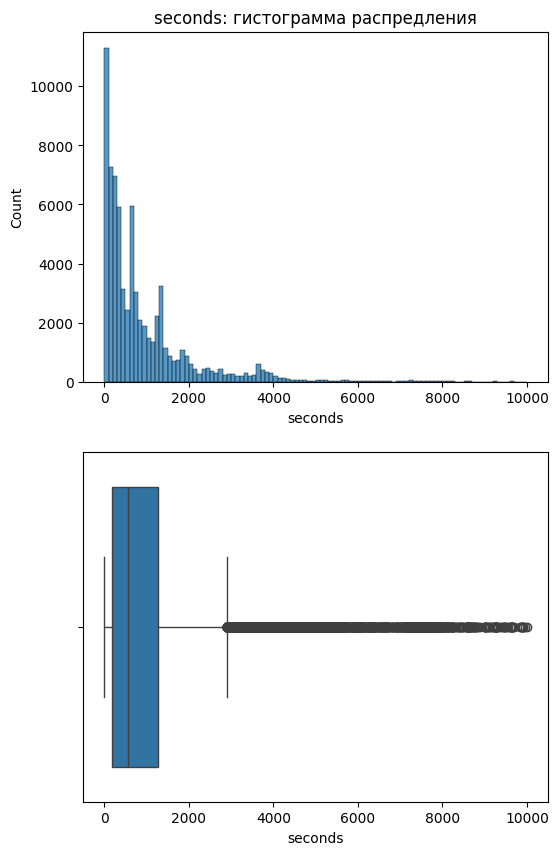

In [15]:
# Визуализируе длительность ролика в секундах (на графике - ролими длительностью не более 10 000 сек)
describe_col_plot(df_train.drop(index=df_train[df_train.seconds > 10000].index, inplace=False), 'seconds', bins=100)
df_train.seconds.describe()

In [16]:
# Оценим количество роликов с нулевой длительностью
zero_sec = df_train[df_train.seconds == 0]['seconds'].count()
print(f'Количетво роликов с нулевой длительности: {zero_sec} - {zero_sec / df_train.shape[0] * 100:.2f}%')

Количетво роликов с нулевой длительности: 1766 - 2.12%


In [17]:
# Проверим ролики с нулевой длительностью
df_train[df_train.seconds == 0]['url'].sample(5)

4290     https://www.youtube.com/watch?v=1jCfs_EqpQQ
10431    https://www.youtube.com/watch?v=HF_xsdeR3jw
35281    https://www.youtube.com/watch?v=JRYUlbmbNJQ
1387     https://www.youtube.com/watch?v=JybKOfPqLjw
33949    https://www.youtube.com/watch?v=Kvg5014tcyM
Name: url, dtype: object

Данные ролики более недоступны на YouTube

### is_shorts

In [18]:
df_train.is_shorts.value_counts(dropna=False) / df_train.shape[0] * 100

is_shorts
0.0    84.935498
NaN    10.497794
1.0     4.566708
Name: count, dtype: float64

### broadcast

In [19]:
df_train.broadcast.value_counts(dropna=False) / df_train.shape[0] * 100

broadcast
none        87.347736
NaN         10.497794
live         2.016593
upcoming     0.137876
Name: count, dtype: float64

### yt_channel_type

In [20]:
df_train.yt_channel_type.value_counts(dropna=False) / df_train.shape[0] * 100

yt_channel_type
Мультфильмы    48.706359
Блогеры        39.449453
Детские        11.519279
Shorts          0.267360
NaN             0.057548
Name: count, dtype: float64

### flag_closed

In [21]:
df_train.flag_closed.value_counts(dropna=False) / df_train.shape[0] * 100

flag_closed
0.0    96.102292
1.0     3.840159
NaN     0.057548
Name: count, dtype: float64

### international

In [22]:
df_train.international.value_counts(dropna=False) / df_train.shape[0] * 100

international
0.0    99.346585
1.0     0.595866
NaN     0.057548
Name: count, dtype: float64

### language

In [23]:
df_train.language.value_counts(dropna=False) / df_train.shape[0] * 100

language
NaN        99.404134
english     0.244581
spanish     0.240984
arabic      0.110301
Name: count, dtype: float64

In [24]:
# Загружаем тестовый датасет
df_test = pd.read_csv('../data/test.csv', lineterminator='\n', parse_dates=True)
df_test.head(3)

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN


In [25]:
# Обзор тестового датасета
data_review(df_test)

Количество строк: 55608 
Количество столбцов: 15 
Явных дубликатов: 0


,Имя столбца,Тип данных,Уникальных значений,"Доля уник.знач., %",Число пропусков,"Доля пропусков, %"
0,date,object,4498,8.1,0,0.00
1,reel_name,object,52006,93.5,3,0.01
2,yt_reel_id,object,55608,100.0,0,0.00
3,url,object,55608,100.0,0,0.00
4,text,object,52960,95.2,0,0.00
5,seconds,float64,5585,10.0,5801,10.43
6,is_shorts,float64,3,0.0,5801,10.43
7,broadcast,object,4,0.0,5801,10.43
8,yt_channel_id,object,207,0.4,24,0.04
9,yt_channel_name,object,203,0.4,28,0.05


Резюме по обзору параметров
1. Имеем датасет: 83 тыс. наблюдений, 16 столбцов, явных дубликатов нет.
2. Таргет (**cartoon**): 45 классов. Пропусков нет. Имеется существенный дисбаланс классов: 93.8% - ролики без лейбла (не относятся ни к одному из отслеживаемых заказчиком проектов), доля 15 наиболее часто встреяющихся классов составляет от 0.1% до 1.0% на каждый класс, остальные - менее 0.01%. Среди мультипликационных проектов присутствуют как мультики Союзмультфильма ("Оранжевая корова", "Зебра в клеточку", "Простоквашино" и др.), так и фильмы других студий ("Маша и Медведь", "Фиксики", "Буба", "Кошечки собачки" и др.).
3. Параметр '**date**': диапазон дат публикации роликов - 16 лет: от 2008-10-08 до 2024-09-15. Пропусков нет. 
4. Выделен новый параметр '**publication_year**' - год публикации. Количество роликов в датасете увеличивается от года к году. Максимум приходится на 2023 год.
5. Параметр '**reel_name**' - строка длиной от 1 до 177 символов, в среднем 59 ±20 знаков. Удалены три записи с пропусками значения. 
6. Параметры '**yt_reel_id**' и '**url**'- уникальный идентификатор и url ролика. Пропусков нет.
7. Параметр '**text**' - сниппет ролика. Длина в среднем 941 ±809 знаков. Пропусков нет.
8. Параметр '**seconds**' - длительность ролика: значение от 0 секунд до 8 часов, в среднем 32 минуты, параметр имеем большую дисперсию, выбросы и аномалии данных. Пропуски значений в 10% случаев.  2% - нулевые значения длительности - данные ролики недоступны на youtube.
9. Параметр '**is_shorts**'. 5.5% - шортсы. 85% - не шортсы. 10,5% - пропуски.
10. Параметр '**broadcast**'. 2% - лайвы. 87% - нет. 10% - пропуски.
11. Параметры '**yt_channel_id**', '**yt_channel_name**', '**yt_ch_url**'. В датасете данные о роликах с более чем 200 каналов. Пропуски 0.05%.
12. Параметр '**yt_channel_type**'. 4 значения: Мультфильмы 49%, блоггеры - 39%, детские каналы - 12%, шортс - 0.2%, пропуски данных 0.05%.
13. Параметр '**flag_closed**'. Закрытые каналы - 3.8%, работающие - 96,1%. Пропуски 0.05%.
14. Параметр '**international**'. Международных/иностранных каналов 0.6%. Пропуски 0.05%.
15. Параметр '**language**'. Английский и испанский язык - по 0.2%, арабский - 0.1%, остальные - язык не определен.  
16. Данные в тестовом датасете соответствуют по структуре и свойствам трейну.





### Выводы по исследовательскому анализу данных.
1. Имеем обучающий датасет: 83 тыс. наблюдений, 15 параметров, 45 классов.
2. Имеем резкий дисбаланс классов. Количество наблюдений для мажорного класса 'none' и минорных (например 'Вспыш') отличаются в 26 000 раз.
3. Перспективные для обучения модели параметры:
    * reel_name, text - основные параметры, содержащие информацию о видео.
    * seconds, is_shorts, broadcast, yt_channel_id (=yt_channel_name), yt_channel_type, international - дополнительные параметры, которые могут быть ассоциированы с таргетом.
4. Параметры, использование которых для обучения нецелесообразно:
    * Дата и год выпуска - использовать нецелесообразно, т.к. при использовании в последующем все новые ролики будут иметь более позднюю дату выпуска, чем в трейне.
    * language - 99,4% значение не определено.
    * yt_reel_id, url, yt_ch_url, flag_closed - технические данные, не несущие информации о свойствах контента.
5. Выявлены ошибки при разметке обучающей выборки:
    * В классе "ЖилаБыла Царевна" - примесь других мультфильмов из других проектов ("Кротик и панда", "Пип и Альба" - не отслеживаются согласно ТЗ, т.е. 'none'), правильная разметка 73%.  
    * В классе "Царевны" примесь видео "ЖилаБыла Царевна", доля правильной разметки всего лишь 29%.
    * В классе "none" - найдены единичные ролики из других классов, но проверить весь датасет не представляется возможным.
6. Тестовый датасет:
    * 55 тыс.наблюдений.
    * Аналогичен по структуре и свойствам данных обучащему.

## Базовое решение

Базовое решение основано на классификации с помощью RandomForest векторов параметра 'text', полученных с помощью tf-idf

In [26]:
# Лемматизируем значения параметра 'text' на трейне
lemmatizer = Mystem()
df_train['text_lem'] = text_lemmatizer(df_train['text'])
df_train.text_lem = df_train.text_lem.apply(lambda x: ' '.join(x).replace('[', '').replace(']', ''))
df_train[['text_lem', 'text']].sample(10)

,text_lem,text
3793,she stole my snacks shorts By guka family s...,[she stole my snacks shorts By guka family sho...
23926,настя и новый игрушка от микки и минни маус...,[Настя и новые игрушки от Микки и Минни маус В...
66599,развивать мультик про машинка для ребенок ....,[Развивающие мультики про машинки для детей. С...
35293,тру джексон 1 сезон 6 серия Nick Rewind рос...,[Тру Джексон 1 Cезон 6 Cерия Nick Rewind Рос...
16591,"ералаш 102 "" экстрасенс "" следующий сюжет...","[Ералаш 102 ""Экстрасенс""] Следующий сюжет htt..."
57999,сказка лис из дом мультик для ребенок 0 а...,[Сказка Лис из Дома Мультик для детей 0] А...
65709,лео и тиг похититель куба серия 67 мультик ...,[Лео и Тиг Похититель Кубы Серия 67 Мультик...
17162,диносити новый мультик для ребенок мультфи...,[ ДиноСити Новые мультики для детей Мультфил...
9025,долли и друг . оригинальный серия весь се...,[ Долли и друзья. Оригинальные серии Все сери...
37964,шарик и шар предсказание союзмультфильм sho...,[Шарик и шар предсказаний Союзмультфильм shor...


In [27]:
# Лемматизируем значения параметра 'text' на тесте
df_test['text_lem'] = text_lemmatizer(df_test['text'])
df_test.text_lem = df_test.text_lem.apply(lambda x: ' '.join(x).replace('[', '').replace(']', ''))
df_test[['text_lem', 'text']].sample(10)

,text_lem,text
13175,лондонский мост разваливаться боб трейн дет...,[Лондонский мост разваливается Боб Трейн детс...
53063,сеня как супергерой помогать мама и папа ...,[Сеня как Супергерой помогает Маме и Папе] Дет...
46702,Om Nom Stories NEW EPISODE COMPILATION Wa...,[Om Nom Stories NEW EPISODE COMPILATION] Watc...
33816,головоломка 2 в реальный жизнь новый эмоция...,[Головоломка 2 в реальной жизни Новые эмоции К...
8101,FUNNY BALLOON POPshorts By Guka Family Show...,[FUNNY BALLOON POPshorts By Guka Family Show] ...
50947,играть с йоко гогольмоголь веселый игра для...,[Играем с ЙОКО Гогольмоголь Весёлые игры дл...
46732,машинка мокас гонка развивать мультик для р...,[Машинки Мокас Гонки Развивающие мультики дл...
5242,мяуч разбираться с грязный посуда чучмяуч s...,[Мяуч разобрался с грязной посудой ЧучМяуч sh...
16504,каквсеначинаться николь на зимний карнавал ...,[КАКВСЕНАЧИНАЛОСЬ НИКОЛЬ НА ЗИМНЕМ КАРНАВАЛЕ В...
12936,п . у . п . с . серия 11 новый мультсериал ...,[П.У.П.С. серия 11 Новый мультсериал Disney]...


In [28]:
# Преобразуем текст в вектор
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(df_train.text_lem)
X_test = tfidf.transform(df_test.text_lem)
y_train = df_train.cartoon

In [29]:
# Обучаем модель-классификатор, получаем предсказания
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
# Сохраняем предсказания в csv в формате для загрузки на kaggle
df_answer = pd.DataFrame(columns=['yt_reel_id', 'cartoon'])
df_answer.yt_reel_id = df_test.yt_reel_id
df_answer.cartoon = y_pred
display(df_answer.cartoon.value_counts())
df_answer.to_csv('../answers/answers_1.csv', index=False)

cartoon
none                        52406
Маша и медведь                557
Говорящий Том                 396
Буба                          351
Кошечки собачки               283
Енотки                        252
Бэтмен                        187
Оранжевая корова              149
ЖилаБыла Царевна              142
Зебра в клеточку              124
Фиксики                        98
Чик-Чирикино                   92
Сумка                          87
Чуддики                        64
Синий трактор                  45
Черепашки Ниндзя               44
My little pony                 43
Чучело-Мяучело                 41
Малышарики                     38
Свинка Пеппа                   37
Пороро                         33
Приключения Пети и Волка       29
Простоквашино                  20
Крутиксы                       15
Смешарики                      15
Трансформеры                   13
Cry babies magic tears         13
Щенячий патруль                 9
Царевны                         6
Кукути

Базовое решение показало точность на тестовых данных на платформе Kaggle f1 = 0.65.

## Эксперименты

Выводы по экспериментам суммированы в таблице:
| Эксперимент | Эффект на метрику| Вывод |
|---|---|---|
|Использование параметра reel_name вместо text| <span style='color: green;'>+18%</span> |берем в качестве параметра reel_name вместо text|
|Очистка датасета от знаков препинания и чисел| <span style='color: green;'>+1%</span> | оставляем в алгоритме обработки данных |
|Очистка датасета от эмодзи| 0 | оставляем в алгоритме обработки данных |
|Удаление стоп-слов| <span style='color: green;'>+0,1%</span> | оставляем в алгоритме обработки данных|
|Добавление категориального признака yt_channel_id| <span style='color: green;'>+1%</span>  |оставляем в качестве признака |
|Добавление признака is_shorts| <span style='color: red;'>-1%</span>  | |
|Добавление признака broadcast| <span style='color: red;'>-9%</span>  | |
|Добавление признака yt_channel_type| <span style='color: red;'>-2%</span>  | |
|Добавление признака closed| <span style='color: red;'>-1%</span>  | |
|Добавление признака "длина 'text'"| <span style='color: green;'>+0.4%</span>  |оставляем в качестве признака |
|Использование как моно- так и биграмм TfidfVectorizer(ngram_range=(1, 2) | <span style='color: red;'>-19%</span> | |
|Использование только биграмм TfidfVectorizer(ngram_range=(2, 2) | <span style='color: red;'>-24%</span> | |
|Использование  моно-, би- и триграмм TfidfVectorizer(ngram_range=(1, 3) | <span style='color: red;'>-21%</span> | |
|Обогащение тренировочного датасета наблюдениями по минорным классам +204 наблюдения (Цветняшки, Буба, Трансформеры, Буба, Финник, Акуленок, Кукутики, Cry babies magic tears, Чудинки, Паровозики Чаггингтон)| <span style='color: green;'>+4%</span>  |оставляем обогащенный датасет |
|Дополнительное обогащение тренировочного датасета наблюдениями по минорным классам | <span style='color: green;'>+2%</span>  |оставляем обогащенный датасет |
|Добавление в параметры именованных сущностей (~8000) | <span style='color: red;'>-0.2%</span>  | |
|Добавление в параметры именованных сущностей с фильтром по длине (~7000) | <span style='color: red;'>-1%</span>  | |
|Undersampling класса 'none' | <span style='color: red;'>-4%</span>  | |
|Использование в качестве классификатора CatBoost | <span style='color: red;'>-20%</span>  | |
|Использование в качестве классификатора нейросетевой модели | <span style='color: red;'>-20%</span>  | |
|Исправление ошибок разметки | <span style='color: red;'>-0.5%</span>  | Хотя на тесте Kaggle метрика чуть проседает, этап обработки оставляем, т.к. на реальных данных качество модели будет выше |

Помимо вышеуказанных экспериментов были скачаны обложки роликов для возможного решения с помощью CV, например на базе ResNet. 
После парсинга изображений выяснилось, что обложки доступны для 86% наблюдений трейна. Ввиду неполноты данных на этапе Kaggle-соревнования от данного подхода отказался, т.к. для теста также данные не полные. Хотя для работы с вновь публикуемыми роликами идея может быть перспективной.

Таким образом, в результате отбора наиболее информативных параметров и обогащения датасета удалось добиться увеличения метрики до 0.92

## Итоговое решение

In [2]:
# Загрузка датасетов
df_train = pd.read_csv('../data/train.csv', lineterminator='\n', parse_dates=True)
df_test = pd.read_csv('../data/test.csv', lineterminator='\n', parse_dates=True)

In [3]:
display(df_train.sample(3))
display(df_test.sample(3))

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
61148,2024-08-08,ВЫПОЛНИЛ 1 000 ЗАДАНИЙ ОТ ГЛУПОГО САЙМОНА ЖЕСТ...,wlAn9NrsU4Y,none,https://www.youtube.com/watch?v=wlAn9NrsU4Y,[ВЫПОЛНИЛ 1 000 ЗАДАНИЙ ОТ ГЛУПОГО САЙМОНА ЖЕС...,1122.0,0.0,none,UCBYvr4SqfGQd5fTmOXVQ4Zw,ГЛЕНТ,https://youtube.com/channel/UCBYvr4SqfGQd5fTmO...,Блогеры,0.0,0.0,NaN
15473,2023-06-16,フラッシュ トイアドベンチャー 侵略 DCKidsInternational,-UoRveBY0P0,none,https://www.youtube.com/watch?v=-UoRveBY0P0,[フラッシュ トイアドベンチャー 侵略 DCKidsInternational] ゾッ...,114.0,0.0,none,UCMt032tr4fOP9NTffiU_oJw,Бэтмен,https://www.youtube.com/c/DCKidsInternational,Мультфильмы,0.0,0.0,NaN
48171,2024-05-29,Who won this time shorts dimakidstv vft,twvVdFaWn2I,none,https://www.youtube.com/watch?v=twvVdFaWn2I,[Who won this time shorts dimakidstv vft] Hell...,17.0,1.0,none,UCb1WBEEfA4e6FOLOKAH5j8w,Dima Kids TV,https://www.youtube.com/channel/UCb1WBEEfA4e6F...,Блогеры,0.0,0.0,NaN


,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
18372,2021-10-16,ЙОКО Йоко супер герой Мультфильмы для детей,AHmLyQUA8do,https://www.youtube.com/watch?v=AHmLyQUA8do,[ЙОКО Йоко супер герой Мультфильмы для детей...,2014.0,0.0,none,UC_YNHyysKLFUm4Fhemi2kdw,Yoko (Йоко),https://youtube.com/channel/UC_YNHyysKLFUm4Fhe...,Мультфильмы,0.0,0.0,NaN
4761,2021-02-20,Om Nom Stories Super Noms Cake for Two Cut t...,4pzYq8fV-I8,https://www.youtube.com/watch?v=4pzYq8fV-I8,[Om Nom Stories Super Noms Cake for Two Cut ...,3469.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN
16552,2014-07-24,Мультфильмы для малышей Руби и ЙоЙо Мамины ...,rLl6BNYjCrA,https://www.youtube.com/watch?v=rLl6BNYjCrA,[Мультфильмы для малышей Руби и ЙоЙо Мамины...,435.0,0.0,none,UCQYY7FZ_Xph6HaYZtKaE-HA,Teremok Baby,https://youtube.com/channel/UCQYY7FZ_Xph6HaYZt...,Мультфильмы,0.0,0.0,NaN


In [4]:
# Обогащение трейна по минорным классам
df_train = data_enrichment(df_train)

Не удалось получить данные: id 4GKRfVV7X для Паровозики Чаттингтон
Не удалось получить данные: id ZgHNtZ9aJ4I для Барбоскины
Не удалось получить данные: id ItPgXaMk5bU для Буба
Не удалось получить данные: id a7mZCHQnM для Лунтик
Не удалось получить данные: id INp42tyY-_ для Смешарики
Не удалось получить данные: id LeT1RnReRxQ для Крутиксы
Добавлено наблюдений: 893 
Размер датасета: (84304, 16)


In [5]:
# Проверим количество классов после обогащения
df_train.cartoon.nunique()

45

In [6]:
# Исправляем ошибки разметки в датасете
df_train = target_correction(df_train)

Исправлено меток классов: 101


In [7]:
# Пайплайн обработки датасетов

# Обработка колонки 'yt_channel_id'
class ChannelIdProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.fillna({'yt_channel_id':'none'}, inplace=True)
        return X

# Обработка колонки 'seconds'
class SecondsProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.fillna({'seconds': 0}, inplace=True)
        return X

# Добавляем параметр text_len - длина сниппета в символах
class TexLenProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['text_len'] = X.text.apply(lambda x: len(x))
        return X

# Обработка параметра reel_name
class ReelNameProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.fillna({'reel_name': ''}, inplace=True)
        X['reel_name_lem'] = text_lemmatizer(X['reel_name'])
        X['reel_name'] = X['reel_name_lem'].apply(text_cleaning)
        #X.drop(columns='reel_name_lem', inplace=True)
        return X

pipeline_feature_prep = Pipeline([
    ('reel_id_processor', ChannelIdProcessor()),
    ('seconds_processor', SecondsProcessor()),
    ('text_len_processor', TexLenProcessor()),
    ('reel_name_processor', ReelNameProcessor())
])

In [8]:
# Запускаем пайплайн подготовки данных
df_train = pipeline_feature_prep.fit_transform(df_train)
df_test = pipeline_feature_prep.transform(df_test)

Лемматизация: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


In [9]:
# Выделяем выборки для обучения модели
X_train = df_train[['reel_name', 'yt_channel_id', 'seconds', 'text_len']]
X_test = df_test[['reel_name', 'yt_channel_id', 'seconds', 'text_len']]
y_train = df_train.cartoon

In [12]:
# Преобразуем данные в матрицу (tf-idf для текстов, кодирование для yt_channel_id)
X_train_m, X_test_m, ohe_yti, tfidf, scaler_sec, scaler_tl = matrix_preparation(X_train, X_test)
print(f'\nРазмеры итоговых матриц: \nX_train: {X_train_m.shape} \nX_test {X_test_m.shape}')

Кодирование yt_channel_id: 0.0350 секунд
Векторизация train: 0.6740 секунд
Векторизация test: 0.4070 секунд
Объединение матриц: 0.0270 секунд

Размеры итоговых матриц: 
X_train: (84304, 31300) 
X_test (55608, 31300)


In [13]:
# Определяем модель и перечень гиперпараметров
clf_rf = RandomForestClassifier()

param_distributions = {
    'n_estimators': np.arange(50, 200, 10),         # Количество деревьев
    'max_depth': [None] + list(np.arange(10, 50, 10)), # Глубина деревьев
    'min_samples_split': [2, 5, 10],                # Минимальное количество примеров для разбиения узла
    'min_samples_leaf': [1, 2, 4],                  # Минимальное количество примеров в листовом узле
    'bootstrap': [True, False]                      # Использование bootstrap выборки
}

rf_random = RandomizedSearchCV(estimator=clf_rf,
                               param_distributions=param_distributions,
                               n_iter=50,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [14]:
# Запускаем обучение модели
rf_random.fit(X_train_m, y_train)
print("Лучшие параметры: ", rf_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


d:\.DATASCIENCE\projects\souz_multfilm\code\souz_mult_venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры:  {'n_estimators': np.int64(180), 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}


In [15]:
# Получаем предсказание на тестовой выборке и сохраняем в csv для загрузки на Kaggle
y_pred = rf_random.predict(X_test_m)
df_answer = pd.DataFrame(columns=['yt_reel_id', 'cartoon'])
df_answer.yt_reel_id = df_test.yt_reel_id
df_answer.cartoon = y_pred
display(df_answer.cartoon.value_counts())
df_answer.to_csv('../answers/answers_41.csv', index=False)

cartoon
none                          52249
Маша и медведь                  557
Говорящий Том                   393
Буба                            352
Кошечки собачки                 292
Енотки                          253
Бэтмен                          235
Оранжевая корова                148
Зебра в клеточку                124
ЖилаБыла Царевна                111
Фиксики                          98
Чик-Чирикино                     92
Сумка                            90
Черепашки Ниндзя                 70
Чуддики                          58
Синий трактор                    51
My little pony                   50
Свинка Пеппа                     42
Малышарики                       39
Чучело-Мяучело                   37
Приключения Пети и Волка         33
Пороро                           32
Смешарики                        27
Трансформеры                     27
Простоквашино                    23
Щенячий патруль                  22
Cry babies magic tears           14
Крутиксы            

На платформе Kaggle получена метрика f1 = 0.92

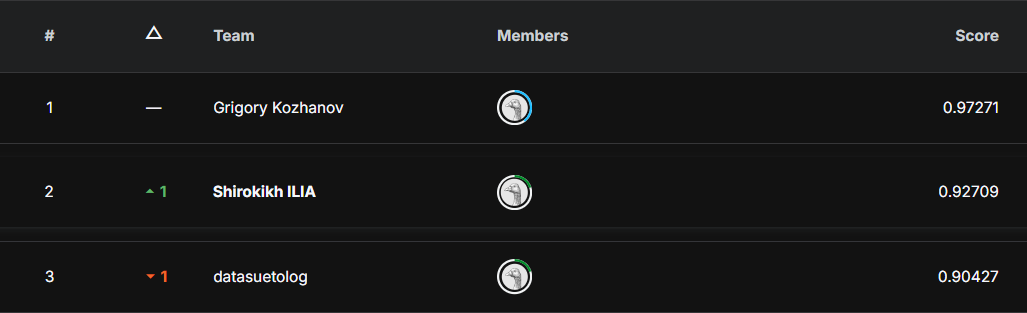

In [16]:
# Сохраняем модель, кодировщик и векторайзер
joblib.dump(rf_random, '../models/final/model_rf.pkl')
joblib.dump(ohe_yti, '../models/final/ohe_yti.pkl')
joblib.dump(tfidf, '../models/final/tfidf.pkl')

['../models/final/tfidf.pkl']

## Отчет по результатам работы
Целью проекта была разработка модели для классификации видеороликов на 45 классов по принадлежности к мультипликационным проектам. Необходимо было максимизровать метрику f1 и оформить решение в виде модуля или функции.
### Данные
Заказчиком предоставлен обучающий датасет. При анализе данных выявлено:  
* размер датасета: 83 тыс. наблюдений, 15 параметров, 45 классов.
* резкий дисбаланс классов. 
* основные парамеры с текстовым описанием роликов: reel_name, text
* дополнительные параметры: seconds, is_shorts, broadcast, yt_channel_id (=yt_channel_name), yt_channel_type, international  
* ошибки в разметке классов, особенно для проектов "Царевны" и "ЖилаБыла Царевна"  

Тестовый датасет:  
* 55 тыс. наблюдений
* аналогичен по структуре и свойствам данных обучающему.

Преобразования обучающего датасета:
1. Обогащение данными с YouTube: добавлено 893 наблюдения по 27-ми минорным классам. 
2. Исправление ошибочной разметки: исправлено 101 наблюдение.
3. Удаление дубликатов, заполнение пропусков.

Выявлены наиболее информативные параметры: reel_name, yt_channel_id, seconds, а также длина текстового описания (text).
1. Обработка текста reel_name:
    * Лемматизация (Mystem из pymystem3)
    * Очистка от цифр, знаков препинания, эмодзи, двойных пробелов, удаление стоп-слов, приведение к нижнему регистру
    * Векторизация методом tf-idf (TfidfVectorizer из sklearn)
2. yt_channel_id - произведено кодирование с помощью OneHotEcoder (sklearn)
3. seconds и text_len - без обработки

### Модель
В качестве модели-классификатора применялись Логистическая регрессия (один против всех), RandomForest, CatBoost, а также нейросетевая модель. 
Наилучшие результаты показал RandomForest с параметрами: {'n_estimators': 180, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}.

Качество модели проверено на тренировочном датасете на платформе Kaggle, на тестовом датасете получена метрика f1 = 0.92.

### Модуль
Cоздан модуль reels_clf.py с функцией reels_clf.  
Входящие параметры функции:  
* api_key - API-key для получения данных с YouTube  
* id_list - список ID видеороликов  

Возвращаемое значение - словарь:  
* ключ словаря - ID ролика  
* значение словаря - результат предсказания. Возможны три варианта возвращаемого значения:  
    * название проекта, к которму относится мультфильм (один из 44, отслеживаемых студией)  
    * 'none' - если ролик не относится ни к одному из отслеживаемых проектов  
    * 'wrong id' - если по указанному ID не удалось получить сведения о ролике на YouTube  

### Перспективы развития
Точность модели классификации видеороликов можно повысить следующими способами:
1. Исправление ошибок разметки в обучающем и тестовом датасетах
2. Уменьшение дисбаланска классов в обучащей выборке за счет еще большего расширения минорных классов
3. Дополнительно исследовать эффект от добавления к параметрам эмбедингов из изображения обложки ролика
4. Исследовать точность нейросетевого подхода (файнтюн предоубченной модели)